# Fake news challenge stance analysis

# Importing libraries, dataset and defining functions

### Library import

In [1]:
pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 33.8 MB/s 
     |████████████████████████████████| 1.2 MB 65.6 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 79.9 MB/s 
     |████████████████████████████████| 6.6 MB 70.6 MB/s 
     |████████████████████████████████| 895 kB 76.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=6ac7aaca614484876741aa46aad3c8549c50fe271ff54f81f626e9cedbfcd1ff
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import os

from scipy.spatial.distance import cosine
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
import spacy

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.naive_bayes import MultinomialNB

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)

from sentence_transformers import SentenceTransformer

from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Loading dataset from the Github repository

In [3]:
# Loading the HEADLINE data into a dataframe
url = 'https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv'
df = pd.read_csv(url,index_col=1)

# Loading the ARTICLE BODY data into a dataframe
url = 'https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv'
df1 = pd.read_csv(url,index_col=0)

In [4]:
# Combining the HEADLINE and ARTICLE BODY columns based on "Body ID" to create one dataframe
df_combined = df.join(df1,
                      on = "Body ID")

In [5]:
# Assigining the required column names to variables for ease of access
HEADLINE_COLUMN = 'Headline'
CONTENT_COLUMN = 'articleBody'
TARGET_COLUMN = 'Stance'

In [6]:
df_combined

,Headline,Stance,articleBody
Body ID,,,
712,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\n\n...
158,Hundreds of Palestinians flee floods in Gaza a...,agree,Hundreds of Palestinians were evacuated from t...
137,"Christian Bale passes on role of Steve Jobs, a...",unrelated,30-year-old Moscow resident was hospitalized w...
1034,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...
1923,Spider burrowed through tourist's stomach and ...,disagree,"Fear not arachnophobes, the story of Bunbury's..."
...,...,...,...
1681,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,unrelated,(CNN) -- Boko Haram laughed off Nigeria's anno...
2419,Brian Williams slams social media for speculat...,unrelated,Along with unveiling the Apple Watch earlier t...
1156,Mexico Says Missing Students Not Found In Firs...,agree,The bodies found in a mass grave were confirme...


### Function definitions

In [7]:
def remove_URL(text):
  # Function to remove URLs from the text data
  url = re.compile(r'https?://\S+|www\.\S+|[a-z]+\.[a-z]+(\S+)?|\(@+[a-zA-Z1-9]+\)')
  return url.sub('', text)


def remove_html(text):
  # Function to remove HTML format strings from the text data
  html = re.compile(r'<.*?>')
  return html.sub('', text)


def remove_punct(text):
  # Function to remove punctuations from the text data
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)


# Creating a variable to store the list of stop words for English language 
stop_words = list(set(stopwords.words('english')))
def remove_stopwords(text):
  # Function to remove stop words from the text data
  word_tokens = word_tokenize(text)
  return ' '.join([w for w in word_tokens if not w.lower() in stop_words])


# Creating a variable to store the details of word lemmatizing strategy as implemented by spacy lemmatizer function
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatizing(text):
  # Function to remove lemmatize the text data
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])


def cosie_similarity(x, y):
  # Function to calculate cosine similarity between two word embeddings
    similarity = 1 - cosine(x, y)
    return similarity


def tfidf_vectors(model, headline, article):
  # Function to generate TFIDFs

  # Vectorizing data
  headline_tfidf = tfidf_owndict.fit_transform(headline.astype('U'))
  article_tfidf = tfidf_owndict.fit_transform(article.astype('U'))

  # Calculating the cosie similarity
  similarity = []
  row_count = headline_tfidf.shape[0]
  for i in range(0, row_count):
      similarity.append(cosie_similarity(headline_tfidf[i].toarray(), article_tfidf[i].toarray()))
  similarity =  np.asarray(similarity).T

  # Combining the vectors to obtain the format [HEAD][COSINE-SIMILARITY][ARTICLE BODY]
  temp = np.append(headline_tfidf.toarray(), similarity[:, None], axis=1)
  tfidf_vector = np.append(temp, article_tfidf.toarray(), axis=1)
  return tfidf_vector


def sentence_embeddings(model, headline_sentences, article_sentences):
  # Function to generate Sentence embeddings

  # Vectorizing data
  headline_embeddings = model.encode(headline_sentences)
  article_embeddings = model.encode(article_sentences)
  
  # Calculating the cosie similarity
  similarity = []
  row_count = headline_embeddings.shape[0]
  for i in range(0, row_count):
      similarity.append(cosie_similarity(headline_embeddings[i], article_embeddings[i]))
  similarity =  np.asarray(similarity).T

  # Combining the vectors to obtain the format [HEAD][COSINE-SIMILARITY][ARTICLE BODY]
  temp = np.append(headline_embeddings, similarity[:, None], axis=1)
  sentence_embedding_vector = np.append(temp, article_embeddings, axis=1)
  return sentence_embedding_vector


def plot_confusion_matrix(y_test, y_pred):
    # Function to plot the confusion matrix for the target labels and predictions
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.suptitle("Confusion matrix", fontsize=14, fontweight="bold");
    plt.xlabel('True label')
    plt.ylabel('Predicted label');
    plt.show()


def model_results(model, train_vector, train_label, test_vector, test_label, arg_max_fun):
  # Function calcualtes the accuracies, classification metrics and confusion matrix
  
  # Printing the accuracies
  print("\033[1mAccuracies:\033[0m")
  # Predicting the labels using train data
  train_predict_label = model.predict(train_vector)
  # Converting the 2-D predict output to 1-D to pass as an argument to the metric generation fucntions
  if arg_max_fun:
    train_predict_label = np.argmax(train_predict_label, axis=1)
  # Printing the training accuracy
  print("Training Accuracy:", accuracy_score(train_label, train_predict_label))

  # Predicting the labels using test data
  test_predict_label = model.predict(test_vector)
  # Converting the 2-D predict output to 1-D to pass as an argument to the metric generation fucntions
  if arg_max_fun:
    test_predict_label = np.argmax(test_predict_label, axis=1)
  # Printing the test accuracy
  print("Testing Accuracy:", accuracy_score(test_label, test_predict_label))

  # Printing the classifcation report
  print("\033[1mClassification report:\033[0m")
  print(metrics.classification_report(test_label, test_predict_label, digits=3))

  # Printing the confusion matrix
  # Building the confusion matrix for test data
  confusion = confusion_matrix(test_label, test_predict_label)
  # Plotting a Heatmap for the confusion matrix
  sns.heatmap(confusion, square=True, annot=True, fmt='d', cmap="YlGnBu",annot_kws={"size": 10}, cbar=False)
  plt.suptitle("Confusion matrix", fontsize=14, fontweight="bold");
  plt.xlabel('True label')
  plt.ylabel('Predicted label');


def dl_history_plot(history, x, y, y_label, x_legend, y_legend):
  # Function to plot the history of the model
  # Creating a dictionary for the history parameters
  dict_keys = history.history.keys()
  history_keys = list()
  for i in history.history.keys():
    history_keys.append(i)
  # Plotting the history
  plt.plot(history.history[history_keys[x]])
  plt.plot(history.history[history_keys[y]])
  plt.suptitle("Model's {} history".format(y_label.lower()), fontsize=16, fontname="Times New Roman", fontweight="bold");
  plt.xlabel('Epoch', fontsize=14, fontname="Times New Roman", fontweight="bold");
  plt.ylabel(y_label, fontsize=14, fontname="Times New Roman", fontweight="bold");
  plt.legend([x_legend, y_legend], loc='upper left',prop={'family': 'Times New Roman'});
  plt.show()


def visualize(data, label, TEXT_COLUMN, body_id):
  # Visualize the data on a WordCloud
    words = ''
    for msg in data[data[TARGET_COLUMN] == label][TEXT_COLUMN][body_id]:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=600).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.suptitle("Word cloud for - column: {}; class: {}; Body ID: {}".format(TEXT_COLUMN, label, body_id), fontsize=12);
    plt.show()

# Analyzing, cleaning and finalizing the datasets

### Cleaning the data

In [8]:
# Cleaning the ARTICLE BODY

# Removing the URLs
df_combined[CONTENT_COLUMN] = df_combined[CONTENT_COLUMN].apply(lambda x: remove_URL(x))

# Removing the HTML tags
df_combined[CONTENT_COLUMN] = df_combined[CONTENT_COLUMN].apply(lambda x: remove_html(x))

# Removing the punctuations
df_combined[CONTENT_COLUMN] = df_combined[CONTENT_COLUMN].apply(lambda x: remove_punct(x))

# Removing the stopwords
df_combined[CONTENT_COLUMN] = df_combined[CONTENT_COLUMN].apply(lambda x: remove_stopwords(x))

# Lemmatizing the text
df_combined[CONTENT_COLUMN] = df_combined[CONTENT_COLUMN].apply(lambda x: lemmatizing(x))

In [9]:
# Cleaning the HEADLINE

# Removing the URLs
df_combined[HEADLINE_COLUMN] = df_combined[HEADLINE_COLUMN].apply(lambda x: remove_URL(x))

# Removing the HTML tags
df_combined[HEADLINE_COLUMN] = df_combined[HEADLINE_COLUMN].apply(lambda x: remove_html(x))

# Removing the punctuations
df_combined[HEADLINE_COLUMN] = df_combined[HEADLINE_COLUMN].apply(lambda x: remove_punct(x))

# Removing the stopwords
df_combined[HEADLINE_COLUMN] = df_combined[HEADLINE_COLUMN].apply(lambda x: remove_stopwords(x))

# Lemmatizing the text
df_combined[HEADLINE_COLUMN] = df_combined[HEADLINE_COLUMN].apply(lambda x: lemmatizing(x))

### Understanding the data

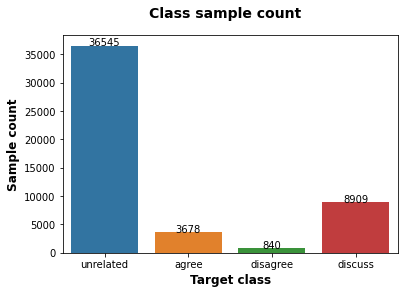

In [10]:
# Converting the target attribute values into categorical data
labels_to_cat = pd.Categorical(df_combined[TARGET_COLUMN])

# Plotting the sample count in each class
ax = sns.countplot(df_combined[TARGET_COLUMN])
for rect in ax.patches:
    ax.annotate(rect.get_height(), (rect.get_x() +
                rect.get_width()/2, rect.get_height() + 0.75), ha='center')
plt.suptitle("Class sample count", fontsize=14, fontweight="bold");
plt.xlabel('Target class', fontsize=12, fontweight="bold");
plt.ylabel('Sample count', fontsize=12, fontweight="bold");

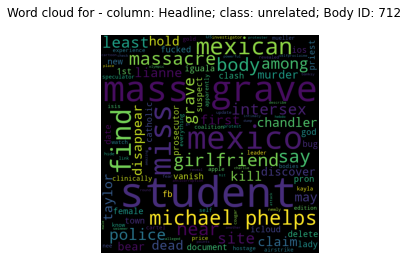

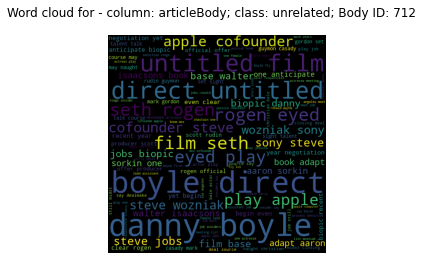

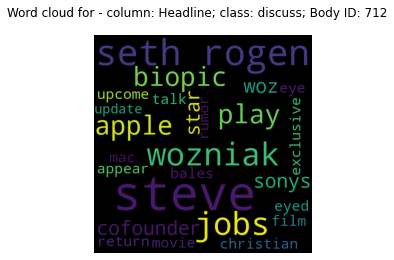

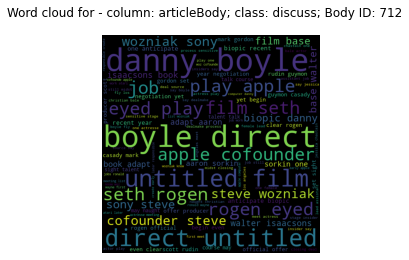

In [11]:
# Using word cloud to under the proximity of words

# Example Body ID = 712
visualize(df_combined, 'unrelated', HEADLINE_COLUMN, 712)
visualize(df_combined, 'unrelated', CONTENT_COLUMN, 712)

visualize(df_combined, 'discuss', HEADLINE_COLUMN, 712)
visualize(df_combined, 'discuss', CONTENT_COLUMN, 712)

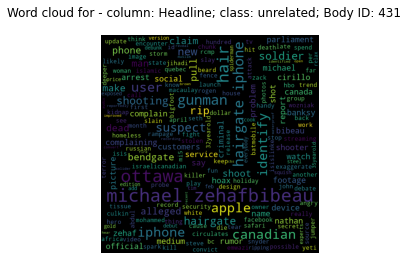

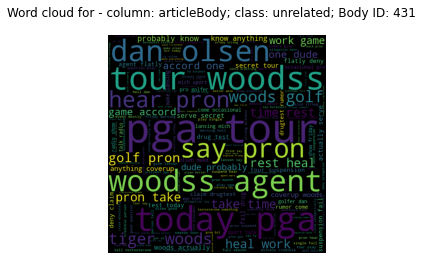

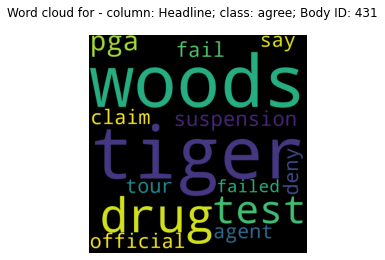

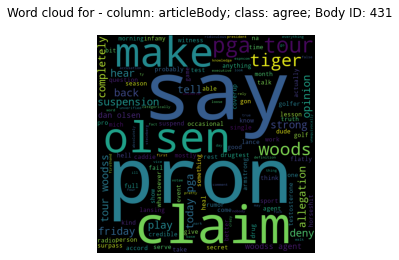

In [12]:
# Using word cloud to under the proximity of words

# Example Body ID = 431
visualize(df_combined, 'unrelated', HEADLINE_COLUMN, 431)
visualize(df_combined, 'unrelated', CONTENT_COLUMN, 431)

visualize(df_combined, 'agree', HEADLINE_COLUMN, 431)
visualize(df_combined, 'agree', CONTENT_COLUMN, 431)

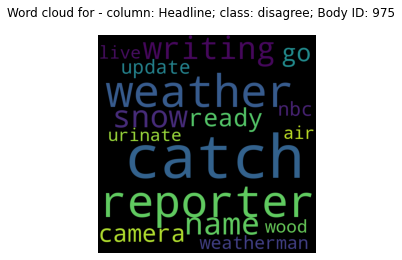

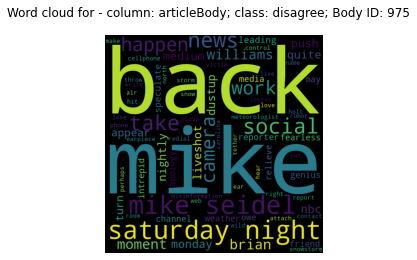

In [13]:
# Using word cloud to under the proximity of words

# Example Body ID = 975
visualize(df_combined, 'disagree', HEADLINE_COLUMN, 975)
visualize(df_combined, 'disagree', CONTENT_COLUMN, 975)

### Updating the labels and indexes

In [14]:
# Reducing the dataset size owing to lack of high computational resources
df_combined = df_combined.head(25000)

In [15]:
# Updating the text class labels to their numerical counterparts
df_combined[TARGET_COLUMN] = df_combined[TARGET_COLUMN].map({"unrelated": 0, "agree": 1, "discuss": 2, "disagree": 3})

# Resetting the indexes to be in order as this step is necessary for Transformers
df_combined.reset_index(inplace=True)

### Creating the dataframe for RELATED class

In [16]:
# Creating a dataframe that only contains the related class data
to_keep = [1, 2, 3]
df_related = df_combined[df_combined.Stance.isin(to_keep)]

### Splitting the entire (both RELATED and UNRELATED) dataset into train, test and validation datasets

In [17]:
# Spliting data set into TRAIN and TEMPORARY datasets
X_train, X_temp, y_train, y_temp = train_test_split(df_combined[HEADLINE_COLUMN], 
                                                    df_combined[TARGET_COLUMN].values , test_size=0.30, random_state=0)

Xa_train, Xa_temp, ya_train, ya_temp = train_test_split(df_combined[CONTENT_COLUMN], 
                                                    df_combined[TARGET_COLUMN].values , test_size=0.30, random_state=0)


#Spliting TEMPORARY data set into TEST and VALIDATION datASETS
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp , test_size=0.33, random_state=0)

Xa_test, Xa_val, ya_test, ya_val = train_test_split(Xa_temp, ya_temp , test_size=0.33, random_state=0)


# Mapping the labels to binary classes
# Creating a dictionary for the mapping
org_labels = [0, 1, 2, 3]
binary_labels = [0, 1, 1, 1]
label_dict = dict(zip(org_labels, binary_labels))

# Creating binary class labels
y_train_bin = np.array([label_dict.get(x,x) for x in y_train])
y_val_bin = np.array([label_dict.get(x,x) for x in y_val])
y_test_bin = np.array([label_dict.get(x,x) for x in y_test])

# Converting the labels to categorical format (One-hot encoding)
y_train_conv = keras.utils.to_categorical(y_train_bin)
y_test_conv = keras.utils.to_categorical(y_test_bin)
y_val_conv = keras.utils.to_categorical(y_val_bin)

### Splitting the RELATED dataset into train, test and validation datasets

In [18]:
# Spliting data set into TRAIN and TEMPORARY datasets
X_train_r, X_temp_r, y_train_r, y_temp_r = train_test_split(df_related[HEADLINE_COLUMN], 
                                                    df_related[TARGET_COLUMN].values , test_size=0.30, random_state=0)

Xa_train_r, Xa_temp_r, ya_train_r, ya_temp_r = train_test_split(df_related[CONTENT_COLUMN], 
                                                    df_related[TARGET_COLUMN].values , test_size=0.30, random_state=0)


#Spliting TEMPORARY data set into TEST and VALIDATION datASETS
X_test_r, X_val_r, y_test_r, y_val_r = train_test_split(X_temp_r, y_temp_r , test_size=0.33, random_state=0)

Xa_test_r, Xa_val_r, ya_test_r, ya_val_r = train_test_split(Xa_temp_r, ya_temp_r , test_size=0.33, random_state=0)


# Mapping the labels to binary classes
# Creating a dictionary for the mapping
three_labels_r = [1, 2, 3]
temp_labels_r = [0, 1, 2]
label_dict_r = dict(zip(three_labels_r, temp_labels_r))

# Creating binary class labels
y_train_r = np.array([label_dict_r.get(x,x) for x in y_train_r])
y_test_r = np.array([label_dict_r.get(x,x) for x in y_test_r])
y_val_r = np.array([label_dict_r.get(x,x) for x in y_val_r])

# Converting the labels to categorical format (One-hot encoding)
y_train_conv_r = keras.utils.to_categorical(y_train_r)
y_test_conv_r = keras.utils.to_categorical(y_test_r)
y_val_conv_r = keras.utils.to_categorical(y_val_r)

### Splitting the entire dataset into train, test and validation datasets

# Analysing the accuracies and performance of TFIDF extrated features with Multinomial Naive Bayes (ML technique) and CNN (DL Techniques)

### Creating the vocabulary using only the train data

In [19]:
# Combining the cleaned article body and headline to create a column with combined text
df_combined["head_body"] = df_combined[HEADLINE_COLUMN] + df_combined[CONTENT_COLUMN]

# Spliting the data set into train and test for creating the vocabulary
X_train_vocab, X_temp, y_train_vocab, y_temp = train_test_split(df_combined["head_body"], 
                                                    df_combined[TARGET_COLUMN].values , test_size=0.30, random_state=0)

# Create the numericalizer TFIDF for lowercase
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)
# Numericalize the train dataset
vocab_tfidf = tfidf.fit_transform(X_train_vocab.values.astype('U'))

# Contains the vocabulary of words
feature_names = tfidf.get_feature_names()
print("Vocabulary size as extracted from the training data:", len(feature_names))

Vocabulary size as extracted from the training data: 22223


### Creating the TFIDF vectors

In [20]:
#Defining the TFIDF vectorizer
tfidf_owndict = TfidfVectorizer(vocabulary = feature_names, decode_error='ignore', lowercase = True, min_df=2)

#Train Data
train_tfidf = tfidf_vectors(tfidf_owndict, X_train, Xa_train)

#Validation data
val_tfidf = tfidf_vectors(tfidf_owndict, X_val, Xa_val)

#Test data
test_tfidf = tfidf_vectors(tfidf_owndict, X_test, Xa_test)

## Multinomial Naive Bayes technique

In [21]:
# Building the MultinomialNB model
model_NB_tfidf = MultinomialNB()

In [22]:
%%time
# Training the model
model_NB_tfidf.fit(train_tfidf, y_train_bin)

CPU times: user 8.55 s, sys: 2.12 s, total: 10.7 s
Wall time: 1.3 s


MultinomialNB()

Accuracies:
Training Accuracy: 0.7962857142857143
Testing Accuracy: 0.7797979797979798
Classification report:
              precision    recall  f1-score   support

           0      0.770     0.994     0.867      1795
           1      0.930     0.215     0.349       680

    accuracy                          0.780      2475
   macro avg      0.850     0.604     0.608      2475
weighted avg      0.814     0.780     0.725      2475



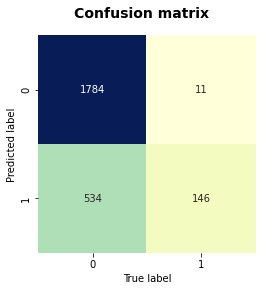

In [23]:
# Results for the model
model_results(model_NB_tfidf, train_tfidf, y_train_bin, val_tfidf, y_val_bin, False)

## CNN technique

In [24]:
# CNN
# https://www.programcreek.com/python/example/89676/keras.layers.Conv1D
model_cnn_tfidf = Sequential()
model_cnn_tfidf.add(Conv1D(256, 5, activation='relu', input_shape=(train_tfidf.shape[1], 1)))
model_cnn_tfidf.add(MaxPooling1D(3))
model_cnn_tfidf.add(Conv1D(128, 3, activation='relu'))
model_cnn_tfidf.add(MaxPooling1D(3))
model_cnn_tfidf.add(Flatten())
model_cnn_tfidf.add(Dense(16, activation='relu'))
model_cnn_tfidf.add(Dropout(0.25))
model_cnn_tfidf.add(Dense(2, activation='softmax'))
model_cnn_tfidf.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
print(model_cnn_tfidf.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44443, 256)        1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14814, 256)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 14812, 128)        98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4937, 128)        0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 631936)            0         
                                                                 
 dense (Dense)               (None, 16)                1

In [25]:
%%time
# Training the model
history_cnn_tfidf = model_cnn_tfidf.fit(
    train_tfidf, y_train_conv, validation_data=(val_tfidf, y_val_conv), batch_size=32, epochs=7
)

Epoch 1/7
547/547 [==============================] - 1163s 2s/step - loss: 0.3540 - accuracy: 0.8471 - val_loss: 0.0822 - val_accuracy: 0.9766
Epoch 2/7
547/547 [==============================] - 1118s 2s/step - loss: 0.0690 - accuracy: 0.9776 - val_loss: 0.0506 - val_accuracy: 0.9875
Epoch 3/7
547/547 [==============================] - 1113s 2s/step - loss: 0.0366 - accuracy: 0.9881 - val_loss: 0.0448 - val_accuracy: 0.9855
Epoch 4/7
547/547 [==============================] - 1109s 2s/step - loss: 0.0245 - accuracy: 0.9912 - val_loss: 0.0526 - val_accuracy: 0.9842
Epoch 5/7
547/547 [==============================] - 1109s 2s/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0539 - val_accuracy: 0.9871
Epoch 6/7
547/547 [==============================] - 1112s 2s/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 0.0517 - val_accuracy: 0.9867
Epoch 7/7
547/547 [==============================] - 1114s 2s/step - loss: 0.0122 - accuracy: 0.9955 - val_loss: 0.0569 - val_accuracy: 0.9867

158/158 [==============================] - 69s 434ms/step - loss: 0.0725 - accuracy: 0.9871
Accuracies:
Training Accuracy: 0.9981714285714286
Testing Accuracy: 0.9870646766169154
Classification report:
              precision    recall  f1-score   support

           0      0.989     0.994     0.991      3652
           1      0.983     0.969     0.976      1373

    accuracy                          0.987      5025
   macro avg      0.986     0.982     0.984      5025
weighted avg      0.987     0.987     0.987      5025



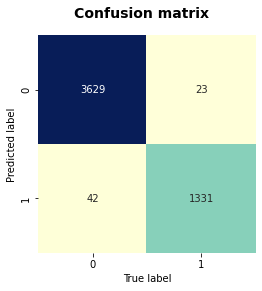

In [26]:
# Evaluating the model
model_cnn_tfidf.evaluate(test_tfidf, y_test_conv, verbose=1)

# Results for the model
model_results(model_cnn_tfidf, train_tfidf, y_train_bin, test_tfidf, y_test_bin, True)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


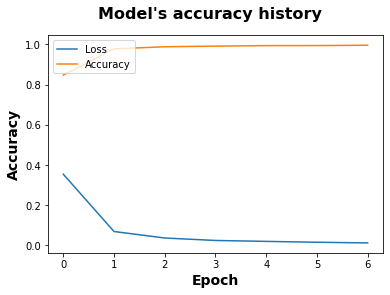

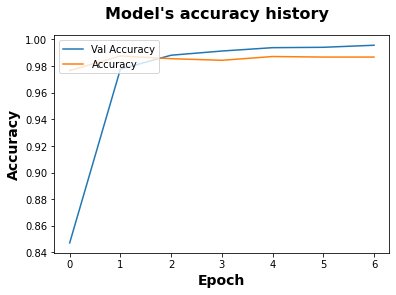

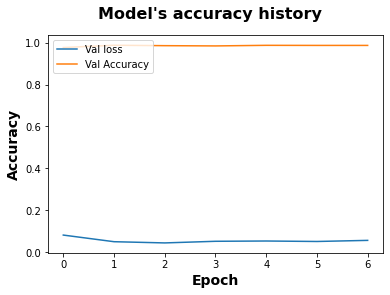

In [27]:
# Plotting the history graphs
dl_history_plot(history_cnn_tfidf, 0, 1, "Accuracy", "Loss", "Accuracy")
dl_history_plot(history_cnn_tfidf, 1, 3, "Accuracy", "Val Accuracy", "Accuracy")
dl_history_plot(history_cnn_tfidf, 2, 3, "Accuracy", "Val loss", "Val Accuracy")

# Analysing the accuracies and performance of BERT (Transformer) extrated features with SVM (ML technique) and CNN (DL Techniques)

### Creating the Transformer sentence embeddings

In [28]:
# Define the sentence transformer model
# https://huggingface.co/sentence-transformers
sentence_transformer = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
sentence_transformer

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [29]:
# Train data
train_bert = sentence_embeddings(sentence_transformer, X_train.values, Xa_train.values)

# Validation data
val_bert = sentence_embeddings(sentence_transformer, X_val.values, Xa_val.values)

# Test data
test_bert = sentence_embeddings(sentence_transformer, X_test.values, Xa_test.values)

## SVM technique

In [30]:
# Building the SVM model
model_svm_bert = SVC(gamma='auto', C=10,
             kernel='rbf', class_weight='balanced')

In [31]:
%%time
# Training the model
model_svm_bert.fit(train_bert, y_train_bin)

CPU times: user 3min 11s, sys: 133 ms, total: 3min 12s
Wall time: 3min 11s


SVC(C=10, class_weight='balanced', gamma='auto')

Accuracies:
Training Accuracy: 0.9748571428571429
Testing Accuracy: 0.9616161616161616
Classification report:
              precision    recall  f1-score   support

           0      0.995     0.952     0.973      1795
           1      0.886     0.987     0.934       680

    accuracy                          0.962      2475
   macro avg      0.941     0.969     0.953      2475
weighted avg      0.965     0.962     0.962      2475



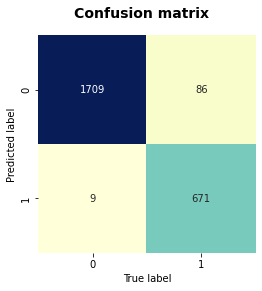

In [32]:
# Results for the model
model_results(model_svm_bert, train_bert, y_train_bin, val_bert, y_val_bin, False)

## CNN technique

In [43]:
# Converting the labels to categorical format
y_train_conv = keras.utils.to_categorical(y_train_bin)
y_test_conv = keras.utils.to_categorical(y_test_bin)
y_val_conv = keras.utils.to_categorical(y_val_bin)

# CNN
# https://www.programcreek.com/python/example/89676/keras.layers.Conv1D
model_cnn_bert = Sequential()
model_cnn_bert.add(Conv1D(128, 5, activation='relu', input_shape=(train_bert.shape[1], 1)))
model_cnn_bert.add(MaxPooling1D(3))
model_cnn_bert.add(Conv1D(64, 3, activation='relu'))
model_cnn_bert.add(MaxPooling1D(3))
model_cnn_bert.add(Flatten())
model_cnn_bert.add(Dense(16, activation='relu'))
model_cnn_bert.add(Dropout(0.25))
model_cnn_bert.add(Dense(2, activation='softmax'))
model_cnn_bert.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn_bert.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1533, 128)         768       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 511, 128)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 509, 64)           24640     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 169, 64)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 10816)             0         
                                                                 
 dense_6 (Dense)             (None, 16)               

In [44]:
%%time
# Training the model
history_cnn_bert = model_cnn_bert.fit(
    train_bert, y_train_conv, validation_data=(val_bert, y_val_conv), batch_size=32, epochs=15
)

Epoch 1/15
547/547 [==============================] - 33s 61ms/step - loss: 0.5557 - accuracy: 0.7333 - val_loss: 0.4999 - val_accuracy: 0.7253
Epoch 2/15
547/547 [==============================] - 33s 60ms/step - loss: 0.4224 - accuracy: 0.7623 - val_loss: 0.3653 - val_accuracy: 0.8570
Epoch 3/15
547/547 [==============================] - 33s 60ms/step - loss: 0.3192 - accuracy: 0.8608 - val_loss: 0.3016 - val_accuracy: 0.8723
Epoch 4/15
547/547 [==============================] - 33s 60ms/step - loss: 0.2524 - accuracy: 0.8999 - val_loss: 0.2267 - val_accuracy: 0.9147
Epoch 5/15
547/547 [==============================] - 33s 61ms/step - loss: 0.2191 - accuracy: 0.9141 - val_loss: 0.1775 - val_accuracy: 0.9434
Epoch 6/15
547/547 [==============================] - 34s 62ms/step - loss: 0.1911 - accuracy: 0.9262 - val_loss: 0.1600 - val_accuracy: 0.9471
Epoch 7/15
547/547 [==============================] - 35s 64ms/step - loss: 0.1704 - accuracy: 0.9345 - val_loss: 0.1611 - val_accuracy:

158/158 [==============================] - 4s 24ms/step - loss: 0.1310 - accuracy: 0.9614
Accuracies:
Training Accuracy: 0.9906285714285714
Testing Accuracy: 0.9613930348258707
Classification report:
              precision    recall  f1-score   support

           0      0.969     0.978     0.974      3652
           1      0.941     0.916     0.928      1373

    accuracy                          0.961      5025
   macro avg      0.955     0.947     0.951      5025
weighted avg      0.961     0.961     0.961      5025



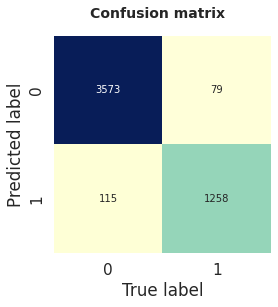

In [45]:
# Evaluating the model
model_cnn_bert.evaluate(test_bert, y_test_conv, verbose=1)

# Results for the model
model_results(model_cnn_bert, train_bert, y_train_bin, test_bert, y_test_bin, True)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


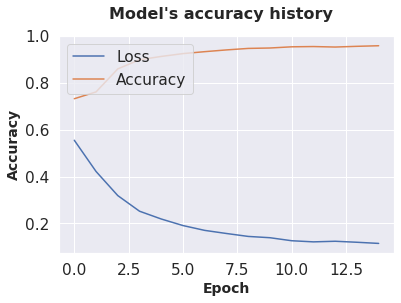

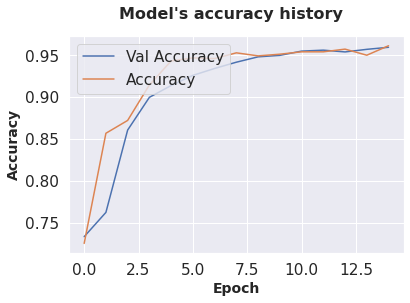

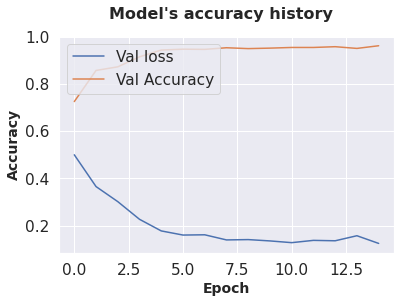

In [46]:
# Plotting the history graphs
dl_history_plot(history_cnn_bert, 0, 1, "Accuracy", "Loss", "Accuracy")
dl_history_plot(history_cnn_bert, 1, 3, "Accuracy", "Val Accuracy", "Accuracy")
dl_history_plot(history_cnn_bert, 2, 3, "Accuracy", "Val loss", "Val Accuracy")

# Deep learning model for the RELATED class

In [37]:
# Train data
train_bert_r = sentence_embeddings(sentence_transformer, X_train_r.values, Xa_train_r.values)

# Validation data
val_bert_r = sentence_embeddings(sentence_transformer, X_val_r.values, Xa_val_r.values)

# Test data
test_bert_r = sentence_embeddings(sentence_transformer, X_test_r.values, Xa_test_r.values)

In [47]:
# CNN
# https://www.programcreek.com/python/example/89676/keras.layers.Conv1D
model_cnn_related = Sequential()
model_cnn_related.add(Conv1D(128, 5, activation='relu', input_shape=(train_bert_r.shape[1], 1)))
model_cnn_related.add(MaxPooling1D(3))
model_cnn_related.add(Conv1D(64, 3, activation='relu'))
model_cnn_related.add(MaxPooling1D(3))
model_cnn_related.add(Flatten())
model_cnn_related.add(Dense(16, activation='relu'))
model_cnn_related.add(Dropout(0.25))
model_cnn_related.add(Dense(3, activation='softmax'))
model_cnn_related.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn_related.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1533, 128)         768       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 511, 128)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 509, 64)           24640     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 169, 64)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 10816)             0         
                                                                 
 dense_8 (Dense)             (None, 16)               

In [48]:
%%time
# Training the model
history_cnn_related = model_cnn_related.fit(
    train_bert_r, y_train_conv_r, validation_data=(val_bert_r, y_val_conv_r), batch_size=32, epochs=15
)

Epoch 1/15
147/147 [==============================] - 9s 61ms/step - loss: 0.7514 - accuracy: 0.6741 - val_loss: 0.6147 - val_accuracy: 0.7474
Epoch 2/15
147/147 [==============================] - 9s 61ms/step - loss: 0.6346 - accuracy: 0.7348 - val_loss: 0.5574 - val_accuracy: 0.7729
Epoch 3/15
147/147 [==============================] - 9s 62ms/step - loss: 0.5823 - accuracy: 0.7452 - val_loss: 0.5488 - val_accuracy: 0.7669
Epoch 4/15
147/147 [==============================] - 9s 61ms/step - loss: 0.5372 - accuracy: 0.7652 - val_loss: 0.4960 - val_accuracy: 0.7714
Epoch 5/15
147/147 [==============================] - 9s 61ms/step - loss: 0.4908 - accuracy: 0.7803 - val_loss: 0.4660 - val_accuracy: 0.7925
Epoch 6/15
147/147 [==============================] - 9s 62ms/step - loss: 0.4515 - accuracy: 0.7940 - val_loss: 0.5217 - val_accuracy: 0.7820
Epoch 7/15
147/147 [==============================] - 9s 62ms/step - loss: 0.4199 - accuracy: 0.7991 - val_loss: 0.4470 - val_accuracy: 0.7955

43/43 [==============================] - 1s 22ms/step - loss: 0.4287 - accuracy: 0.8147
Accuracies:
Training Accuracy: 0.9308216262239251
Testing Accuracy: 0.8146775389177169
Classification report:
              precision    recall  f1-score   support

           0      0.686     0.754     0.718       370
           1      0.936     0.863     0.898       885
           2      0.444     0.596     0.509        94

    accuracy                          0.815      1349
   macro avg      0.689     0.738     0.709      1349
weighted avg      0.833     0.815     0.822      1349



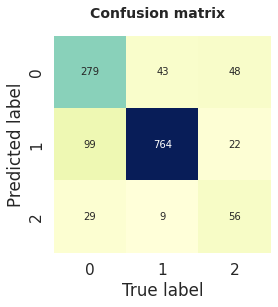

In [49]:
# Evaluating the model
model_cnn_related.evaluate(test_bert_r, y_test_conv_r, verbose=1)

# Results for the model
model_results(model_cnn_related, train_bert_r, y_train_r, test_bert_r, y_test_r, True)

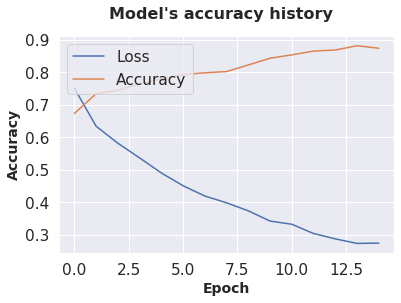

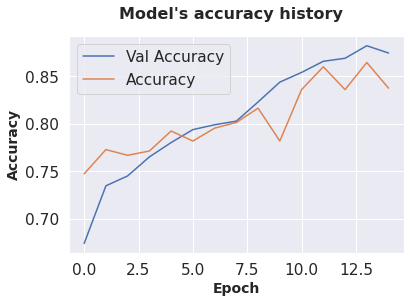

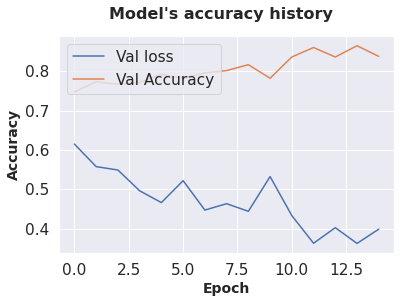

In [50]:
# Plotting the history graphs
dl_history_plot(history_cnn_related, 0, 1, "Accuracy", "Loss", "Accuracy")
dl_history_plot(history_cnn_related, 1, 3, "Accuracy", "Val Accuracy", "Accuracy")
dl_history_plot(history_cnn_related, 2, 3, "Accuracy", "Val loss", "Val Accuracy")

# End-to-End ensemble

Accuray and classifcation metrics for BINARY classification model
Testing Accuracy: 0.9605970149253731
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3652
           1       0.89      0.98      0.93      1373

    accuracy                           0.96      5025
   macro avg       0.94      0.97      0.95      5025
weighted avg       0.96      0.96      0.96      5025



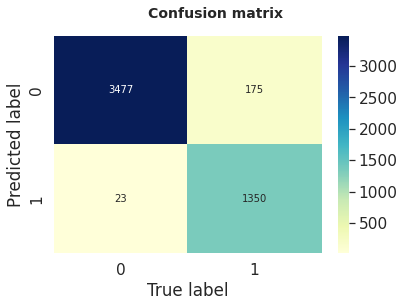



Accuray and classifcation metrics for END-TO-END classification model
Testing Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3652
           1       0.71      0.89      0.79       370
           2       0.86      0.89      0.88       928
           3       0.57      0.80      0.67        75

    accuracy                           0.93      5025
   macro avg       0.78      0.88      0.83      5025
weighted avg       0.94      0.93      0.94      5025



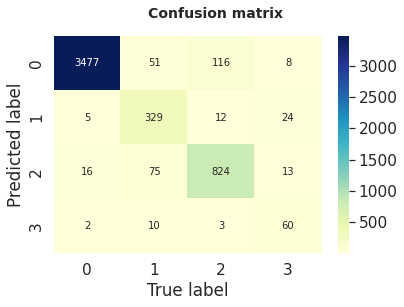

In [52]:
# Predicting the values using the BERT and SVM model
predicted_labels = model_svm_bert.predict(test_bert)

# Identifying the indexes of the labels predictied as RELATED
predicted_related_index = [i for i in range(len(predicted_labels)) if predicted_labels[i] == 1]

# Using the indexes to pull out the required test sentence embeddings
test_related_bert = test_bert[predicted_related_index]

# Updating the dictionary
label_dict_r = dict(zip(temp_labels_r, three_labels_r))

# Predict the lables using the Related LSTM model
predicted_labels_related = model_cnn_related.predict(test_related_bert)
predicted_labels_related = np.argmax(predicted_labels_related, axis=1)
predicted_labels_related = np.array([label_dict_r.get(x,x) for x in predicted_labels_related])

# Model Accuracy - Binary model
print("\033[1mAccuray and classifcation metrics for BINARY classification model\033[0m")
print("Testing Accuracy:", accuracy_score(y_test_bin, predicted_labels))

# Print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_test_bin, predicted_labels))
plot_confusion_matrix(y_test_bin, predicted_labels)

# Iterating to replace the values
j=0
for i in range(0,predicted_labels.shape[0]):
  if predicted_labels[i] == 1:
    predicted_labels[i] = predicted_labels_related[j]
    j+=1

# Model Accuracy - End-toEnd model
print("\n\n\033[1mAccuray and classifcation metrics for END-TO-END classification model\033[0m")
print("Testing Accuracy:", accuracy_score(y_test, predicted_labels))

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_test, predicted_labels))
plot_confusion_matrix(y_test, predicted_labels)